In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
train=pd.read_csv('df_final.csv')

In [4]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,target_dis
0,530839,0.0,Oh really?,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,1,0,0.0,0,4,0
1,5748613,0.0,Off point as usual.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,approved,0,0,0,3,4,0.0,4,4,0
2,578912,0.2,Ummm....I'm the one who gave you that citation...,0.0,0.0,0.0,0.2,0.0,NaN,NaN,...,approved,0,0,0,1,0,0.0,0,5,1
3,5752481,0.2,"Uh-huh.\n\nI didn't say he used ""all caps"" for...",0.0,0.0,0.0,0.2,0.0,NaN,NaN,...,approved,0,0,0,0,0,0.0,0,5,1
4,5335441,0.0,An exercise. Write your name backwards in cur...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,0,0,0.0,0,4,0


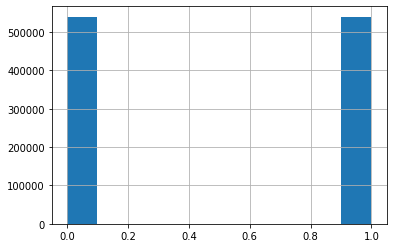

In [5]:
train.target_dis.hist()

In [6]:
### Preprocess

In [7]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(token)
    return result

In [8]:
preprocessed_comments = train['comment_text'].sample(200000).map(preprocess)

In [9]:
listToks = preprocessed_comments.values

In [10]:
dictionary = gensim.corpora.Dictionary(preprocessed_comments)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=75000)

In [11]:
###Convert to bank of words

In [12]:
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_comments]

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [13]:
#Parametrical Sweep of n_topics and Compute Coherence Score
limit=15
c_v = [] # valores de coherencia 
u_mass = []
lm_list = []

for num_topics in range(1, limit):
  lm = LdaModel(corpus=corpus_tfidf, num_topics=num_topics, passes=5, iterations=50, id2word=dictionary)  
  lm_list.append(lm)
    
  cm_cv = CoherenceModel(model=lm, texts=listToks, coherence='c_v')
  c_v.append(cm_cv.get_coherence())
    
  cm_umass = CoherenceModel(model=lm, corpus=corpus_tfidf, coherence='u_mass')
  u_mass.append(cm_umass.get_coherence())

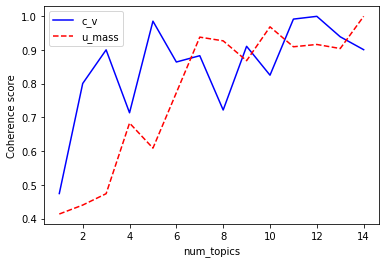

In [14]:
# Graphical Representation
u_mass_abs = list(map(abs, u_mass))
u_mass_max = max(u_mass_abs)
u_mass_esc = list(map(lambda x: x/u_mass_max, u_mass_abs))
c_v_abs =list(map(abs, c_v))
c_v_max = max(c_v_abs)
c_v_esc = list(map(lambda x: x/c_v_max, c_v_abs))
x = range(1, limit)

plt.plot(x, c_v_esc, 'b-', x, u_mass_esc, 'r--')
plt.xlabel("num_topics")
plt.ylabel("Coherence score")
plt.legend(("c_v", "u_mass"), loc='best')
plt.show()

In [15]:
#Final LDA optimum number of topics

In [19]:
optimum_topics=8
lda_model=lm_list[optimum_topics-1]

In [20]:
topic_info = lda_model.print_topics(num_topics=200, num_words=10)
for i, topic in enumerate(topic_info[:200]):
    print("Train topic {}: {}".format(i, topic))

Train topic 0: (0, '0.011*"www" + 0.010*"com" + 0.008*"https" + 0.007*"http" + 0.004*"youtube" + 0.004*"watch" + 0.004*"org" + 0.004*"korea" + 0.003*"caused" + 0.003*"north"')
Train topic 1: (1, '0.008*"lol" + 0.006*"said" + 0.005*"removed" + 0.005*"moron" + 0.005*"trolls" + 0.004*"awesome" + 0.004*"pathetic" + 0.004*"thugs" + 0.003*"disgusting" + 0.003*"kim"')
Train topic 2: (2, '0.004*"people" + 0.004*"like" + 0.004*"money" + 0.003*"time" + 0.003*"government" + 0.003*"tax" + 0.003*"state" + 0.003*"need" + 0.003*"years" + 0.003*"pay"')
Train topic 3: (3, '0.007*"trump" + 0.005*"like" + 0.004*"people" + 0.004*"right" + 0.004*"know" + 0.003*"think" + 0.003*"white" + 0.003*"president" + 0.003*"good" + 0.003*"women"')
Train topic 4: (4, '0.004*"rail" + 0.003*"schools" + 0.002*"building" + 0.002*"project" + 0.002*"pot" + 0.002*"season" + 0.002*"traffic" + 0.002*"football" + 0.002*"taxpayer" + 0.002*"plans"')
Train topic 5: (5, '0.003*"perfect" + 0.003*"gary" + 0.003*"mental" + 0.003*"wynne

In [ ]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.save_html(vis, "LDAVis_train.html")